In [14]:
from caveclient import CAVEclient
import os
import matplotlib.pyplot as plt
import seaborn as sea
import numpy as np 

import sys
sys.path.append('utils')
from FANC_utils import filter_syn_df, compute_connectivity_matrix 

In [3]:
# Initialize CAVEclient
# This step requires an authentication token, see https://caveclient.readthedocs.io/en/latest/guide/authentication.html
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)
client.materialize.version = 840

In [4]:
# IDs of GABAergic neurons presynaptic to claw and hook
ids_dict = dict()
ids_dict['13B_claw'] = [648518346484847261] 
ids_dict['19A_claw'] = [648518346531401754, 
                        648518346472653065,  
                        648518346488555913,
                        648518346498429489,
                        648518346502916595,
                        648518346488659278,
                        648518346521506809,
                        648518346518741215,
                        648518346465091957,
                        648518346494217863,
                        648518346499593822,
                        648518346501344355,
                        648518346491096865]
ids_dict['Chief_9A_hook'] = [648518346496946148]
ids_dict['Other_9A_hook'] = [648518346479847574, 
                             648518346479837078,
                             648518346498002535,
                             648518346479879156,
                             648518346467364359,
                             648518346486716621]
ids_dict['13B_hook'] = [648518346502572199]
ids_dict['19A_hook'] = [648518346479427282, 
                        648518346494008718]

In [5]:
ids = list(ids_dict.values())
ids = [item for i in ids for item in i]

In [6]:
# Query input synapses 
syn_df = client.materialize.synapse_query(post_ids=ids)

In [7]:
# Remove connections less than syn_thresh from syn_df 
syn_thresh = 3;
syn_df_filt = filter_syn_df(syn_df, syn_thresh)

In [8]:
# Get neuron information
neuron_info_df = client.materialize.query_table('neuron_information')

In [10]:
# Get IDs of descending neurons
tag = 'descending'
target_ids = neuron_info_df.pt_root_id[neuron_info_df.tag==tag].tolist()

In [11]:
# Find synapses with descending neurons
ix_to_include = []
for ix, i in syn_df_filt.iterrows():
    if syn_df_filt.pre_pt_root_id[ix] in target_ids: 
        ix_to_include.append(ix)

In [12]:
# Remove connections with neurons other than descending neurons
syn_df_filt_filt = syn_df_filt.loc[ix_to_include]

In [15]:
# Compute connectivity matrix 
conn_mat, pre_ids, post_ids = compute_connectivity_matrix(syn_df_filt_filt)

In [51]:
# Sort columns 
sort_idx = []
for i in ids:
    if i in post_ids:
        sort_idx.append(post_ids.index(i))   

# Sort columns of conn_mat and post IDs
conn_mat_sorted = conn_mat[:,sort_idx]
post_ids_sorted = [post_ids[i] for i in sort_idx]

# Sort rows
idx_list = []
for ix, i in enumerate(pre_ids):
    # Get first column index where conn_mat_sorted>0
    first_col_idx = next(x[0] for x in enumerate(conn_mat_sorted[ix,:]) if x[1] > 0)
    idx_list.append([ix, first_col_idx])

# Sort idx_list
idx_list_sorted = sorted(idx_list, key = lambda x: (x[1]), reverse = False)

# Get sort idx (first element of each list)
sort_idx = [i[0] for i in idx_list_sorted]

# Sort rows of conn_mat and pre IDs
conn_mat_sorted = conn_mat_sorted[sort_idx,:]
pre_ids_sorted = [pre_ids[i] for i in sort_idx]

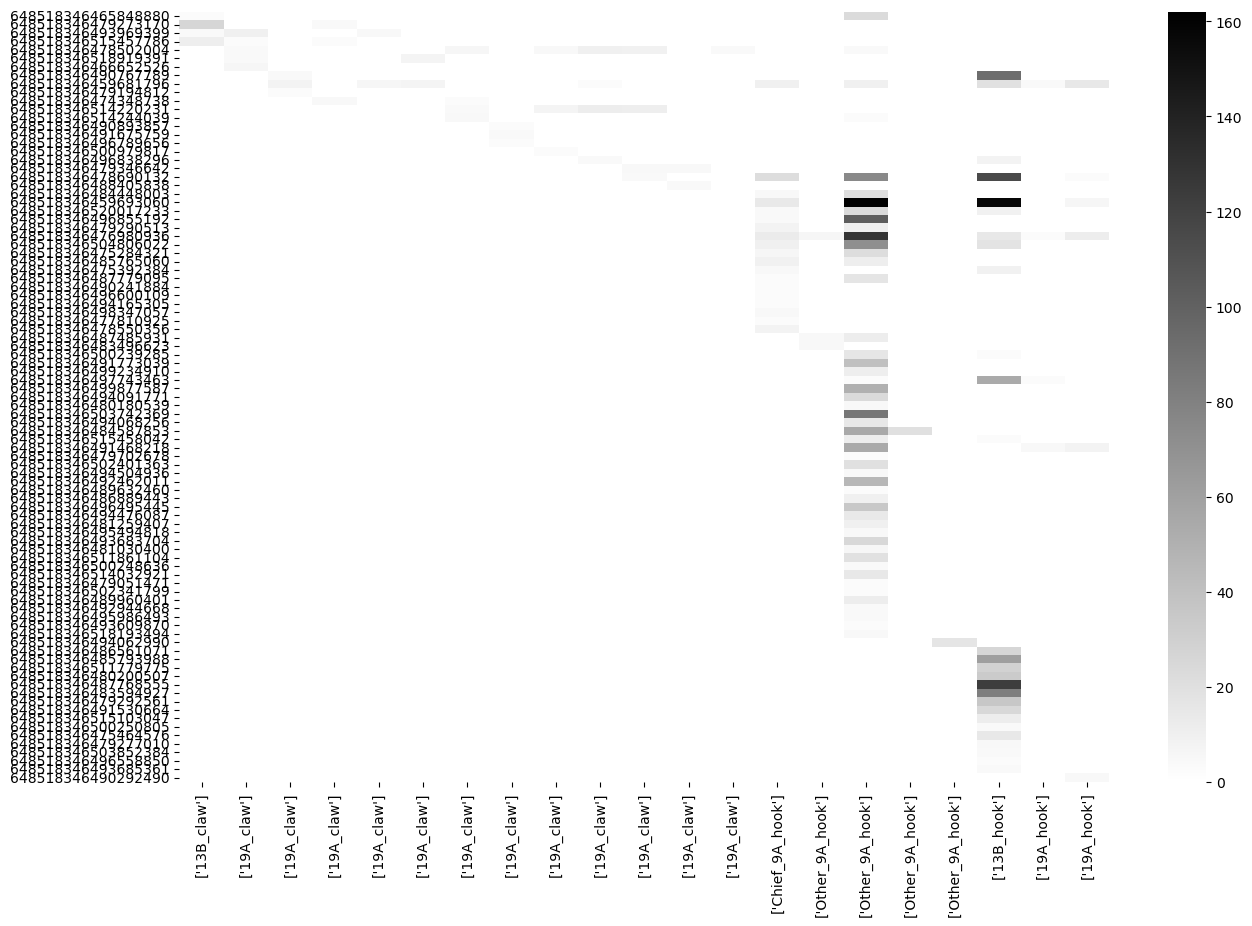

In [52]:
# Plot connectivity matrix
fig = plt.figure(figsize=(15,10))
cmap = sea.color_palette("gray_r", as_cmap=True)
xticklabels = []
for i in post_ids_sorted:
    xticklabels.append([k for k, v in ids_dict.items() if i in v])
yticklabels = pre_ids_sorted
sea.heatmap(conn_mat_sorted, 
            cmap=cmap, 
            xticklabels=xticklabels, 
            yticklabels=yticklabels)
plt.show()

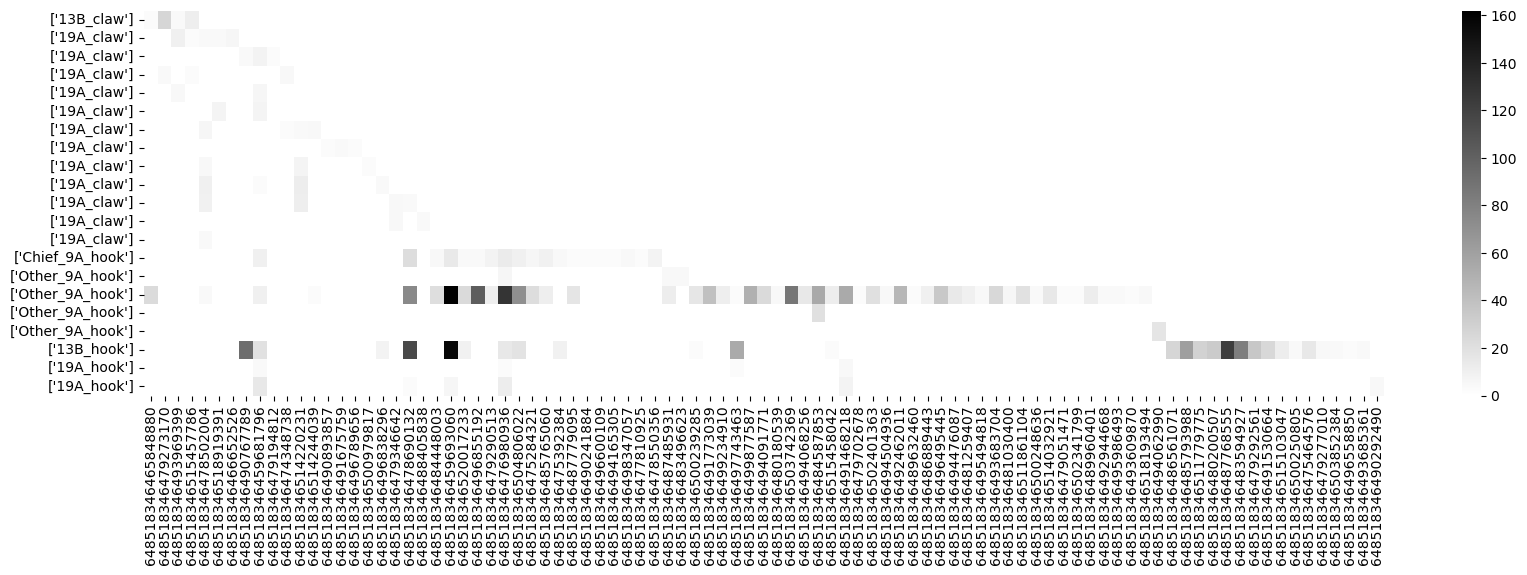

In [56]:
# Plot transposed connectivity matrix
fig = plt.figure(figsize=(20,5))
cmap = sea.color_palette("gray_r", as_cmap=True)
yticklabels = []
for i in post_ids_sorted:
    yticklabels.append([k for k, v in ids_dict.items() if i in v])
xticklabels = pre_ids_sorted
sea.heatmap(conn_mat_sorted.transpose(), 
            cmap=cmap, 
            xticklabels=xticklabels, 
            yticklabels=yticklabels)
plt.show()

In [57]:
# Read out tags of descending neurons
tags = []
for i in pre_ids_sorted:
    tags.append(neuron_info_df.tag[neuron_info_df.pt_root_id == i].tolist())
tags

[['central neuron', 'descending', 'Dallmann et al. 2023'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending', 'Dallmann et al. 2023'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending'],
 ['central neuron',
  'descending',
  'Lesser Azevedo et al. 2023',
  'Dallmann et al. 2023'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending', 'Lesser Azevedo et al. 2023'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending', 'Dallmann et al. 2023'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending', 'Dallmann et al. 2023'],
 ['central neuron', 'descending'],
 ['central neuron', 'descending', 'Dallmann et al. 2023'],
 ['central neuron',


In [63]:
# Find column index of specific tag
tag = 'BDN2'
for ix, i in enumerate(tags):
    if tag in i:
        print(ix)

22


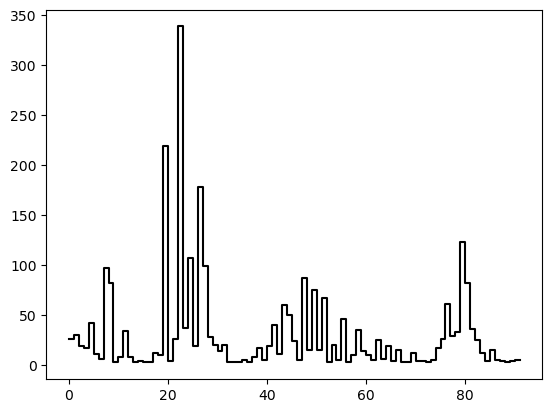

In [50]:
# Plot distribution of synapses
n_syn = np.sum(conn_mat_sorted.transpose(),axis=0)
# For columns, set axis=0
# For rows, set axis=1
plt.step(range(len(n_syn)+1), np.insert(n_syn, 0, n_syn[0]), color=[0,0,0]) # For step function, duplicate first value
plt.show()